<a href="https://colab.research.google.com/github/kocsis-david/LipReadingModel/blob/master/modeltrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import csv
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
def save_data(lips, Y, data_type):
    with open(f'{data_type}_lips.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        header = ['label']
        for i in range(lips[0].shape[0]): #frames
            for j in range(lips[0].shape[1]): #height
                for k in range(lips[0].shape[2]): #width
                    header.append(f'pixel_{i}_{j}_{k}')
        writer.writerow(header)
        for i in range(len(lips)):
            row = [Y[i].argmax()]
            current_lips = lips[i].flatten()
            for j in range(len(current_lips)):
                row.append(current_lips[j])
            writer.writerow(row)


def load_data():
    X_train = pd.read_csv('/content/drive/MyDrive/lips/train_lips.csv')
    Y_train = X_train['label']
    del X_train['label']
    X_valid = pd.read_csv('/content/drive/MyDrive/lips/valid_lips.csv')
    Y_valid = X_valid['label']
    del X_valid['label']

    X_test = pd.read_csv('/content/drive/MyDrive/lips/test_lips.csv')
    Y_test = X_test['label']
    del X_test['label']
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

In [1]:
!pip install pandas
!pip install scikit-learn

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# loading the data from the csv files
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = load_data()
import numpy as np
x_train = np.array(X_train, dtype='float32').reshape(-1, 11, 60, 100, 1)
x_valid = np.array(X_valid, dtype='float32').reshape(-1, 11, 60, 100, 1)
x_test = np.array(X_test, dtype='float32').reshape(-1, 11, 60, 100, 1)

onehot_encoder = OneHotEncoder()

Y_train_reshaped = np.array(Y_train).reshape(-1, 1)
Y_valid_reshaped = np.array(Y_valid).reshape(-1, 1)
Y_test_reshaped = np.array(Y_test).reshape(-1, 1)

Y_train_onehot = onehot_encoder.fit_transform(Y_train_reshaped)
Y_valid_onehot = onehot_encoder.fit_transform(Y_valid_reshaped)
Y_test_onehot = onehot_encoder.fit_transform(Y_test_reshaped)

# Convert one-hot encoded arrays to dense arrays
Y_train = Y_train_onehot.toarray()
Y_valid = Y_valid_onehot.toarray()
Y_test = Y_test_onehot.toarray()


In [6]:
mean=x_train.mean(axis=0)
std=x_train.std(axis=0)

X_train=np.array((x_train-mean)/std)
x_train=None
X_valid=np.array((x_valid-mean)/std)
x_valid=None
X_test=np.array((x_test-mean)/std)
x_test=None

print(X_train.shape)


(4768, 11, 60, 100, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Input, \
    ReLU, GlobalAveragePooling3D, add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation

output_shape = 6
input = Input(shape=(11, 60, 100, 1))

'''block_0'''
b0_conv3d_1 = Conv3D(64, kernel_size=(2, 3, 3), padding='same', use_bias=False,
                     name='b0_conv3d_1', kernel_initializer='he_normal')(input)
b0_relu_1 = ReLU(name='b0_relu_1')(b0_conv3d_1)
b0_bn_1 = BatchNormalization(name='b0_bn_1')(b0_relu_1)
b0_out = MaxPooling3D(pool_size=(2, 2, 2))(b0_bn_1)

'''block_1'''
b1_cnv3d_1 = Conv3D(filters=16, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same',
                    use_bias=False, name='b1_cnv3d_1', kernel_initializer='he_normal')(b0_out)
b1_relu_1 = ReLU(name='b1_relu_1')(b1_cnv3d_1)
b1_bn_1 = BatchNormalization(name='b1_bn_1')(b1_relu_1)  # size: 14*14

b1_cnv3d_2 = Conv3D(filters=32, kernel_size=(1, 1, 1), strides=(2, 2, 2), padding='same',
                    use_bias=False, name='b1_cnv3d_2', kernel_initializer='he_normal')(b1_bn_1)
b1_relu_2 = ReLU(name='b1_relu_2')(b1_cnv3d_2)
b1_out = BatchNormalization(name='b1_out')(b1_relu_2)  # size: 14*14

'''block 2'''
b2_cnv3d_1 = Conv3D(filters=32, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b2_cnv3d_1', kernel_initializer='he_normal')(b1_out)
b2_relu_1 = ReLU(name='b2_relu_1')(b2_cnv3d_1)
b2_bn_1 = BatchNormalization(name='b2_bn_1')(b2_relu_1)  # size: 14*14

b2_add = add([b1_out, b2_bn_1])  #

b2_cnv3d_2 = Conv3D(filters=64, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same',
                    use_bias=False, name='b2_cnv3d_2', kernel_initializer='he_normal')(b2_add)
b2_relu_2 = ReLU(name='b2_relu_2')(b2_cnv3d_2)
b2_out = BatchNormalization(name='b2_bn_2')(b2_relu_2)  # size: 7*7

'''block 3'''
b3_cnv3d_1 = Conv3D(filters=64, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b3_cnv3d_1', kernel_initializer='he_normal')(b2_out)
b3_relu_1 = ReLU(name='b3_relu_1')(b3_cnv3d_1)
b3_bn_1 = BatchNormalization(name='b3_bn_1')(b3_relu_1)  # size: 7*7

b3_add = add([b2_out, b3_bn_1])  #

b3_cnv3d_2 = Conv3D(filters=128, kernel_size=(3, 3, 3), strides=(2, 2, 2), padding='same',
                    use_bias=False, name='b3_cnv3d_2', kernel_initializer='he_normal')(b3_add)
b3_relu_2 = ReLU(name='b3_relu_2')(b3_cnv3d_2)
b3_out = BatchNormalization(name='b3_out')(b3_relu_2)  # size: 3*3

'''block 4'''
from tensorflow.keras.layers import Activation
activation = 'wavenet'
skip_connections = []
use_skip_connections = False
original_x = b3_out
b4_tempconv1 = Conv3D(filters=32, kernel_size=(2,2,2),dilation_rate=(1,1,1), padding='same')(b3_out)
if activation == 'norm_relu':
    x = Activation('relu')(b4_tempconv1)
    x = BatchNormalization(x)
elif activation == 'wavenet':
    tanh_out = Activation('tanh')(b4_tempconv1)
    sigm_out = Activation('sigmoid')(b4_tempconv1)
    x= tf.keras.layers.multiply([tanh_out, sigm_out])
else:
    x = Activation(activation)(b4_tempconv1)

b4_spatialdropout1d =tf.keras.layers.SpatialDropout3D(0.2)(x)

x = Conv3D(32, 1, padding='same')(b4_spatialdropout1d)
original_x= Conv3D(32, 1, padding='same')(original_x)
res_x = tf.keras.layers.add([original_x, x])
skip_connections.append(x)

original_x = res_x
b4_tempconv1 = Conv3D(filters=32, kernel_size=(2,2,2),dilation_rate=(1,1,1), padding='same')(res_x)
if activation == 'norm_relu':
    x = Activation('relu')(b4_tempconv1)
    x = BatchNormalization(x)
elif activation == 'wavenet':
    tanh_out = Activation('tanh')(b4_tempconv1)
    sigm_out = Activation('sigmoid')(b4_tempconv1)
    x= tf.keras.layers.multiply([tanh_out, sigm_out])
else:
    x = Activation(activation)(b4_tempconv1)

b4_spatialdropout1d =tf.keras.layers.SpatialDropout3D(0.2)(x)

x = Conv3D(32, 1, padding='same')(b4_spatialdropout1d)
original_x= Conv3D(32, 1, padding='same')(original_x)
res_x = tf.keras.layers.add([original_x, x])
skip_connections.append(x)

original_x = res_x
b4_tempconv1 = Conv3D(filters=32, kernel_size=(2,2,2),dilation_rate=(1,1,1), padding='same')(res_x)
if activation == 'norm_relu':
    x = Activation('relu')(b4_tempconv1)
    x = BatchNormalization(x)
elif activation == 'wavenet':
    tanh_out = Activation('tanh')(b4_tempconv1)
    sigm_out = Activation('sigmoid')(b4_tempconv1)
    x= tf.keras.layers.multiply([tanh_out, sigm_out])
else:
    x = Activation(activation)(b4_tempconv1)

b4_spatialdropout1d =tf.keras.layers.SpatialDropout3D(0.2)(x)

x = Conv3D(32, 1, padding='same')(b4_spatialdropout1d)
original_x= Conv3D(32, 1, padding='same')(original_x)
res_x = tf.keras.layers.add([original_x, x])
skip_connections.append(x)

if use_skip_connections:
    res_x = tf.keras.layers.add(skip_connections)

x=Activation('relu')(res_x)
'''block 5'''

#tcn_out=tf.keras.layers.MultiHeadAttention(num_heads=12, key_dim=2, value_dim=2)(tcn_out,tcn_out,tcn_out)

flatten = Flatten()(x)
last_layer = Dense(128, activation='relu')(flatten)
output = Dense(output_shape, name='model_output', activation=None,
               kernel_initializer='he_uniform')(last_layer)
output = Activation('softmax')(output)
model = Model(input, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 11, 60, 100, 0                                            
__________________________________________________________________________________________________
b0_conv3d_1 (Conv3D)            (None, 11, 60, 100,  1152        input_4[0][0]                    
__________________________________________________________________________________________________
b0_relu_1 (ReLU)                (None, 11, 60, 100,  0           b0_conv3d_1[0][0]                
__________________________________________________________________________________________________
b0_bn_1 (BatchNormalization)    (None, 11, 60, 100,  256         b0_relu_1[0][0]                  
____________________________________________________________________________________________

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=10, restore_best_weights=True,
                                      min_delta=0.001)
model.fit(X_train, Y_train, batch_size=32, epochs=30, verbose=1, validation_data=(X_valid, Y_valid,), callbacks=[es])

Train on 4768 samples, validate on 241 samples
Epoch 1/30
4768/4768 [==============================] - 26s 6ms/sample - loss: 1.5952 - accuracy: 0.3440 - val_loss: 1.4133 - val_accuracy: 0.4149
Epoch 2/30
4768/4768 [==============================] - 25s 5ms/sample - loss: 1.1403 - accuracy: 0.5495 - val_loss: 1.2267 - val_accuracy: 0.5062
Epoch 3/30
4768/4768 [==============================] - 24s 5ms/sample - loss: 0.9173 - accuracy: 0.6518 - val_loss: 1.2214 - val_accuracy: 0.5311
Epoch 4/30
4768/4768 [==============================] - 25s 5ms/sample - loss: 0.7604 - accuracy: 0.7125 - val_loss: 1.2177 - val_accuracy: 0.5436
Epoch 5/30
4768/4768 [==============================] - 25s 5ms/sample - loss: 0.6459 - accuracy: 0.7513 - val_loss: 1.1900 - val_accuracy: 0.5934
Epoch 6/30
4768/4768 [==============================] - 24s 5ms/sample - loss: 0.5695 - accuracy: 0.7785 - val_loss: 1.3767 - val_accuracy: 0.5768
Epoch 7/30
4768/4768 [==============================] - 24s 5ms/sample 

In [ ]:
from sklearn.metrics import classification_report

preds = model.predict(X_test)

print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))

              precision    recall  f1-score   support

           0       0.55      0.42      0.48        50
           1       0.68      0.69      0.68        36
           2       0.52      0.54      0.53        50
           3       0.41      0.50      0.45        28
           4       0.62      0.62      0.62        50
           5       0.41      0.45      0.43        31

    accuracy                           0.54       245
   macro avg       0.53      0.54      0.53       245
weighted avg       0.54      0.54      0.54       245


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling3D, Flatten,LSTM, Reshape, Dense, Dropout, BatchNormalization, Input, ReLU, GlobalAveragePooling2D, add
from keras.models import Model

output_shape = 2
input = Input(shape=(11, 60, 100, 1))

'''block_0'''
b0_conv3d_1 = Conv3D(64, kernel_size=(2, 3, 3), padding='same', use_bias=False,
                     name='b0_conv3d_1', kernel_initializer = 'he_normal')(input)
b0_relu_1 = ReLU(name='b0_relu_1')(b0_conv3d_1)
b0_bn_1 = BatchNormalization(name='b0_bn_1')(b0_relu_1)
b0_out =  MaxPooling3D(pool_size=(1, 2, 2))(b0_bn_1)

'''block_1'''
b1_cnv3d_1 = Conv3D(filters=16, kernel_size=(1, 2, 2), strides=(1, 1, 1), padding='same',
                        use_bias=False, name='b1_cnv3d_1', kernel_initializer=HeNormal())(b0_out)
b1_relu_1 = ReLU(name='b1_relu_1')(b1_cnv3d_1)
b1_bn_1 = BatchNormalization(name='b1_bn_1')(b1_relu_1)  # size: 14*14

b1_cnv3d_2 = Conv3D(filters=32, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b1_cnv3d_2', kernel_initializer=HeNormal())(b1_bn_1)
b1_relu_2 = ReLU(name='b1_relu_2')(b1_cnv3d_2)
b1_out = BatchNormalization(name='b1_out')(b1_relu_2)  # size: 14*14


'''block 2'''
b2_cnv3d_1 = Conv3D(filters=32, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b2_cnv3d_1', kernel_initializer=HeNormal())(b1_out)
b2_relu_1 = ReLU(name='b2_relu_1')(b2_cnv3d_1)
b2_bn_1 = BatchNormalization(name='b2_bn_1')(b2_relu_1)  

b2_add = add([b1_out, b2_bn_1])  #

b2_cnv3d_2 = Conv3D(filters=64, kernel_size=(3, 3, 3), strides=(1, 2, 2), padding='same',
                    use_bias=False, name='b2_cnv3d_2', kernel_initializer=HeNormal())(b2_add)
b2_relu_2 = ReLU(name='b2_relu_2')(b2_cnv3d_2)
b2_out = BatchNormalization(name='b2_bn_2')(b2_relu_2)  # size: 7*7

'''block 3'''
b3_cnv3d_1 = Conv3D(filters=64, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b3_cnv3d_1', kernel_initializer=HeNormal())(b2_out)
b3_relu_1 = ReLU(name='b3_relu_1')(b3_cnv3d_1)
b3_bn_1 = BatchNormalization(name='b3_bn_1')(b3_relu_1)  # size: 7*7

b3_add = add([b2_out, b3_bn_1])  #

b3_cnv3d_2 = Conv3D(filters=128, kernel_size=(2, 2, 2), strides=(1, 2, 2), padding='same',
                    use_bias=False, name='b3_cnv3d_2', kernel_initializer=HeNormal())(b3_add)
b3_relu_2 = ReLU(name='b3_relu_2')(b3_cnv3d_2)
b3_out = BatchNormalization(name='b3_out')(b3_relu_2)  # size: 3*3


'''block 4'''
# b4_avg_p = GlobalAveragePooling2D()(b3_out)
b4_flatten = Flatten()(b3_out)
b4_reshape = Reshape(target_shape=(11, -1))(b4_flatten)

'''lstm'''
lstm = LSTM(units = 256, name='lstm')(b4_reshape)
dropout = Dropout(rate = 0.4, name='dropout')(lstm)
dense_1 = Dense(units = 128, name='dense_1')(dropout)


output = Dense(output_shape, name='model_output', activation='softmax',
                       kernel_initializer='he_uniform')(dense_1)

model = Model(input, output)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 11, 60, 100, 0                                            
__________________________________________________________________________________________________
b0_conv3d_1 (Conv3D)            (None, 11, 60, 100,  1152        input_3[0][0]                    
__________________________________________________________________________________________________
b0_relu_1 (ReLU)                (None, 11, 60, 100,  0           b0_conv3d_1[0][0]                
__________________________________________________________________________________________________
b0_bn_1 (BatchNormalization)    (None, 11, 60, 100,  256         b0_relu_1[0][0]                  
____________________________________________________________________________________________

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=10, restore_best_weights=True,
                                      min_delta=0.001)
model.fit(X_train, Y_train, batch_size=32, epochs=30, verbose=1, validation_data=(X_valid, Y_valid,), callbacks=[es])

Train on 4768 samples, validate on 241 samples
Epoch 1/30
4768/4768 [==============================] - 32s 7ms/sample - loss: 1.5266 - accuracy: 0.3563 - val_loss: 1.4923 - val_accuracy: 0.3776
Epoch 2/30
4768/4768 [==============================] - 25s 5ms/sample - loss: 1.2260 - accuracy: 0.5113 - val_loss: 1.3212 - val_accuracy: 0.4606
Epoch 3/30
4768/4768 [==============================] - 25s 5ms/sample - loss: 1.0550 - accuracy: 0.5866 - val_loss: 1.0830 - val_accuracy: 0.5643
Epoch 4/30
4768/4768 [==============================] - 25s 5ms/sample - loss: 0.9201 - accuracy: 0.6420 - val_loss: 1.1174 - val_accuracy: 0.5477
Epoch 5/30
4768/4768 [==============================] - 25s 5ms/sample - loss: 0.8087 - accuracy: 0.6883 - val_loss: 1.1355 - val_accuracy: 0.5768
Epoch 6/30
4768/4768 [==============================] - 25s 5ms/sample - loss: 0.6931 - accuracy: 0.7341 - val_loss: 1.1277 - val_accuracy: 0.6183
Epoch 7/30
4768/4768 [==============================] - 25s 5ms/sample 

In [ ]:
from sklearn.metrics import classification_report

preds = model.predict(X_test)

print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))

              precision    recall  f1-score   support

           0       0.52      0.68      0.59        50
           1       0.65      0.61      0.63        36
           2       0.69      0.40      0.51        50
           3       0.52      0.54      0.53        28
           4       0.67      0.66      0.67        50
           5       0.46      0.58      0.51        31

    accuracy                           0.58       245
   macro avg       0.59      0.58      0.57       245
weighted avg       0.60      0.58      0.58       245


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Input, \
    ReLU, GlobalAveragePooling3D, add
from tensorflow.keras.models import Model


output_shape = 6
input = Input(shape=(11, 60, 100, 1))

'''block_0'''
b0_conv3d_1 = Conv3D(64, kernel_size=(2, 3, 3), padding='same', use_bias=False,
                     name='b0_conv3d_1', kernel_initializer='he_normal')(input)
b0_relu_1 = ReLU(name='b0_relu_1')(b0_conv3d_1)
b0_bn_1 = BatchNormalization(name='b0_bn_1')(b0_relu_1)

class C2DResnet18(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(C2DResnet18, self).__init__(**kwargs)

    def call(self, inputs):
        x=inputs
        for i in range(2):
            x = Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                    use_bias=False, name=f'b0_conv3d_{i}', kernel_initializer='he_normal')(x)
            x = ReLU(name=f'b0_relu_{i}')(x)
            x = BatchNormalization(name=f'b0_bn_{i}')(x)
            x = Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                    use_bias=False, name=f'b0_conv3d_{i}', kernel_initializer='he_normal')(x)
            x = ReLU(name=f'b0_relu_{i}')(x)
            x = BatchNormalization(name=f'b0_bn_{i}')(x)
            x = add([inputs, x])

        return x


'''block 2'''
b2_cnv3d_1 = Conv3D(filters=32, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b2_cnv3d_1', kernel_initializer='he_normal')(b1_out)
b2_relu_1 = ReLU(name='b2_relu_1')(b2_cnv3d_1)
b2_bn_1 = BatchNormalization(name='b2_bn_1')(b2_relu_1)  # size: 14*14

b2_add = add([b1_out, b2_bn_1])  #

b2_cnv3d_2 = Conv3D(filters=64, kernel_size=(3, 3, 3), strides=(1, 2, 2),padding='same',
                    use_bias=False, name='b2_cnv3d_2', kernel_initializer='he_normal')(b2_add)
b2_relu_2 = ReLU(name='b2_relu_2')(b2_cnv3d_2)
b2_out = BatchNormalization(name='b2_bn_2')(b2_relu_2)  # size: 7*7

'''block 3'''
b3_cnv3d_1 = Conv3D(filters=64, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b3_cnv3d_1', kernel_initializer='he_normal')(b2_out)
b3_relu_1 = ReLU(name='b3_relu_1')(b3_cnv3d_1)
b3_bn_1 = BatchNormalization(name='b3_bn_1')(b3_relu_1)  # size: 7*7

b3_add = add([b2_out, b3_bn_1])  #

b3_cnv3d_2 = Conv3D(filters=128, kernel_size=(3, 3, 3), padding='same',
                    use_bias=False, name='b3_cnv3d_2', kernel_initializer='he_normal')(b3_add)
b3_relu_2 = ReLU(name='b3_relu_2')(b3_cnv3d_2)
b3_out = BatchNormalization(name='b3_out')(b3_relu_2)  # size: 3*3

'''block 4'''

b4_cnv3d_1 = Conv3D(filters=64, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b3_cnv3d_1', kernel_initializer='he_normal')(b3_out)
b4_relu_1 = ReLU(name='b3_relu_1')(b3_cnv3d_1)
b4_bn_1 = BatchNormalization(name='b3_bn_1')(b3_relu_1)  # size: 7*7

b4_add = add([b2_out, b3_bn_1])  #

b4_cnv3d_2 = Conv3D(filters=128, kernel_size=(3, 3, 3), strides=(1, 2, 2), padding='same',
                    use_bias=False, name='b3_cnv3d_2', kernel_initializer='he_normal')(b3_add)
b4_relu_2 = ReLU(name='b3_relu_2')(b3_cnv3d_2)
b4_out = BatchNormalization(name='b3_out')(b3_relu_2)


class MyLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MyLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Perform your TensorFlow operations here
        # For example, let's say tf_fn is a function that reshapes the input tensor
        output = tf.reshape(inputs, (-1,11, 30*512))  # Replace with your desired shape
        return output



reshaped=MyLayer()(b4_out)
bi_lstm =tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512,return_sequences=True))(reshaped)
dropout = tf.keras.layers.Dropout(0.5)(bi_lstm)
bi_lstm2 =tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512))(reshaped)
dropout2 = tf.keras.layers.Dropout(0.5)(bi_lstm2)
last_layer = Dense(128, activation='relu')(dropout2)
output = Dense(output_shape, name='model_output', activation='softmax',
               kernel_initializer='he_uniform')(last_layer)
model = Model(input, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Input, \
    ReLU, GlobalAveragePooling3D, add
from tensorflow.keras.models import Model


output_shape = 6
input = Input(shape=(11, 60, 100, 1))

'''block_0'''
b0_conv3d_1 = Conv3D(64, kernel_size=(2, 3, 3),strides=(1,2,3), padding='same', use_bias=False,
                     name='b0_conv3d_1', kernel_initializer='he_normal')(input)
b0_relu_1 = ReLU(name='b0_relu_1')(b0_conv3d_1)
b0_bn_1 = BatchNormalization(name='b0_bn_1')(b0_relu_1)


'''block_1'''
b1_cnv3d_1 = Conv3D(filters=16, kernel_size=(3, 3, 3) ,padding='same',
                    use_bias=False, name='b1_cnv3d_1', kernel_initializer='he_normal')(b0_bn_1)
b1_relu_1 = ReLU(name='b1_relu_1')(b1_cnv3d_1)
b1_bn_1 = BatchNormalization(name='b1_bn_1')(b1_relu_1)  # size: 14*14

b1_cnv3d_2 = Conv3D(filters=32, kernel_size=(1, 1, 1), padding='same',
                    use_bias=False, name='b1_cnv3d_2', kernel_initializer='he_normal')(b1_bn_1)
b1_relu_2 = ReLU(name='b1_relu_2')(b1_cnv3d_2)
b1_out = BatchNormalization(name='b1_out')(b1_relu_2)  # size: 14*14

'''block 2'''
b2_cnv3d_1 = Conv3D(filters=32, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b2_cnv3d_1', kernel_initializer='he_normal')(b1_out)
b2_relu_1 = ReLU(name='b2_relu_1')(b2_cnv3d_1)
b2_bn_1 = BatchNormalization(name='b2_bn_1')(b2_relu_1)  # size: 14*14

b2_add = add([b1_out, b2_bn_1])  #

b2_cnv3d_2 = Conv3D(filters=64, kernel_size=(3, 3, 3), strides=(1, 3, 4),padding='same',
                    use_bias=False, name='b2_cnv3d_2', kernel_initializer='he_normal')(b2_add)
b2_relu_2 = ReLU(name='b2_relu_2')(b2_cnv3d_2)
b2_out = BatchNormalization(name='b2_out')(b2_relu_2)  # size: 7*7

'''block 3'''
b3_cnv3d_1 = Conv3D(filters=64, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b3_cnv3d_1', kernel_initializer='he_normal')(b2_out)
b3_relu_1 = ReLU(name='b3_relu_1')(b3_cnv3d_1)
b3_bn_1 = BatchNormalization(name='b3_bn_1')(b3_relu_1)  # size: 7*7

b3_add = add([b2_out, b3_bn_1])  #

b3_cnv3d_2 = Conv3D(filters=64, kernel_size=(3, 3, 3), padding='same',
                    use_bias=False, name='b3_cnv3d_2', kernel_initializer='he_normal')(b3_add)
b3_relu_2 = ReLU(name='b3_relu_2')(b3_cnv3d_2)
b3_out = BatchNormalization(name='b3_out')(b3_relu_2)  # size: 3*3

'''block 4'''

b4_cnv3d_1 = Conv3D(filters=64, kernel_size=(1, 1, 1), strides=(1, 1, 1), padding='same',
                    use_bias=False, name='b4_cnv3d_1', kernel_initializer='he_normal')(b3_out)
b4_relu_1 = ReLU(name='b4_relu_1')(b4_cnv3d_1)
b4_bn_1 = BatchNormalization(name='b4_bn_1')(b4_relu_1)  # size: 7*7

b4_add = add([b3_out, b4_bn_1])  #

b4_cnv3d_2 = Conv3D(filters=128, kernel_size=(3, 3, 3), strides=(1, 2, 2), padding='same',
                    use_bias=False, name='b4_cnv3d_2', kernel_initializer='he_normal')(b4_add)
b4_relu_2 = ReLU(name='b4_relu_2')(b4_cnv3d_2)
b4_out = BatchNormalization(name='b4_out')(b4_relu_2)


class Reshaper(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Reshaper, self).__init__(**kwargs)

    def call(self, inputs):
        # Perform your TensorFlow operations here
        # For example, let's say tf_fn is a function that reshapes the input tensor
        output = tf.reshape(inputs, (-1,11,25*128))  # Replace with your desired shape
        return output



class Expanddim(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Expanddim, self).__init__(**kwargs)

    def call(self, inputs):
        # Perform your TensorFlow operations here
        # For example, let's say tf_fn is a function that reshapes the input tensor
        output = tf.expand_dims(inputs, axis=-1)  # Replace with your desired shape
        return output

class SEAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(SEAttention, self).__init__(**kwargs)
        self.lstm = tf.keras.layers.LSTM(512)
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.dense1 = tf.keras.layers.Dense(512, activation='relu')
        self.dense2 = tf.keras.layers.Dense(512, activation='sigmoid')
    def call(self, inputs):
        # Perform your TensorFlow operations here
        # For example, let's say tf_fn is a function that reshapes the input tensor
        temp=self.lstm(inputs)
        x=Expanddim()(temp)
        x = self.global_avg_pool(x)
        x = self.dense1(x)
        x = self.dense2(x)
        output = tf.keras.layers.multiply([temp, x])
        return output

class TemporalBlock(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size, strides, dilation_rate, dropout, **kwargs):
        super(TemporalBlock, self).__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv1D(filters=out_channels, kernel_size=kernel_size, strides=strides,
                                            padding='causal', dilation_rate=dilation_rate, activation='relu')
        self.conv2 = tf.keras.layers.Conv1D(filters=out_channels, kernel_size=kernel_size, strides=strides,
                                            padding='causal', dilation_rate=dilation_rate, activation='relu')
        self.downsample = None
        self.out_channels = out_channels
        self.strides = strides
        self.dropout = tf.keras.layers.Dropout(dropout)

    def build(self, __input_shape):
        in_channels = __input_shape[-1]
        if in_channels != self.out_channels:
            self.downsample = tf.keras.Sequential()
            self.downsample.add(tf.keras.layers.Conv1D(filters=self.out_channels, kernel_size=1, strides=self.strides))
            self.downsample.add(tf.keras.layers.BatchNormalization())



    def call(self, inputs, training=True):
        in_channels = inputs.shape[-1]



        residual = inputs

        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.dropout(x, training=training)
        if(x.shape[-1]==residual.shape[-1]):
            x = x + residual
        elif self.downsample is not None:
            x = x + self.downsample(residual)

        return x


reshaped=Reshaper()(b4_out)

temporal1=TemporalBlock(64, 4, 1, 2, 0.5)(reshaped)
sea=SEAttention()(temporal1)
upshape1=Expanddim()(sea)
temporal2=TemporalBlock(128, 8, 1, 4, 0.5)(upshape1)
sea2=SEAttention()(temporal2)
upshape2=Expanddim()(sea2)
temporal3=TemporalBlock(256, 8, 1, 8, 0.5)(upshape2)
sea3=SEAttention()(temporal3)
upshape3=Expanddim()(sea3)
temporal4=TemporalBlock(128, 8, 1, 10, 0.5)(upshape3)

output = Dense(output_shape, name='model_output', activation='softmax',
               kernel_initializer='he_uniform')(sea2)
model = Model(input, output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 11, 60, 100, 1)]     0         []                            
                                                                                                  
 b0_conv3d_1 (Conv3D)        (None, 11, 30, 34, 64)       1152      ['input_1[0][0]']             
                                                                                                  
 b0_relu_1 (ReLU)            (None, 11, 30, 34, 64)       0         ['b0_conv3d_1[0][0]']         
                                                                                                  
 b0_bn_1 (BatchNormalizatio  (None, 11, 30, 34, 64)       256       ['b0_relu_1[0][0]']           
 n)                                                                                           

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=10, restore_best_weights=True,
                                      min_delta=0.001)
model.fit(X_train, Y_train, batch_size=32, epochs=30, verbose=1, validation_data=(X_valid, Y_valid,), callbacks=[es])

Epoch 1/30
 19/149 [==>...........................] - ETA: 6:49 - loss: 0.7514 - accuracy: 0.7023

KeyboardInterrupt: 

Eval

In [10]:
from sklearn.metrics import classification_report

preds = model.predict(X_test)

print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))

8/8 [==============================] - 7s 706ms/step
              precision    recall  f1-score   support

           0       0.67      0.64      0.65        50
           1       0.68      0.78      0.73        36
           2       0.50      0.54      0.52        50
           3       0.71      0.89      0.79        28
           4       0.76      0.68      0.72        50
           5       0.55      0.39      0.45        31

    accuracy                           0.64       245
   macro avg       0.64      0.65      0.64       245
weighted avg       0.64      0.64      0.64       245


<Axes: >

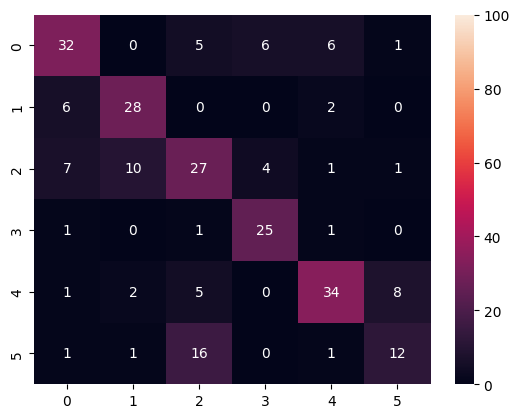

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf=confusion_matrix(np.argmax(Y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)

In [13]:
from sklearn.metrics import classification_report

preds = model.predict(X_test)

print(classification_report(np.argmax(Y_test,1),np.argmax(preds,1)))

8/8 [==============================] - 6s 696ms/step
              precision    recall  f1-score   support

           0       0.77      0.66      0.71        50
           1       0.70      0.83      0.76        36
           2       0.42      0.60      0.50        50
           3       0.75      0.75      0.75        28
           4       0.81      0.70      0.75        50
           5       0.71      0.39      0.50        31

    accuracy                           0.66       245
   macro avg       0.69      0.66      0.66       245
weighted avg       0.69      0.66      0.66       245
